<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/2.deglint_sampling/deglint_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import packages

In [1]:
#import packages used
import ee
import pandas as pd
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import math
import geemap
import os
import math

In [2]:
#authenticate and initialize google earth engine (also necessary for geemap)
ee.Authenticate()
ee.Initialize(project='ee-curuai') #change project name here

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections corrected to BOA

## Landsat 7 BOA

importar coleção com correção Py6S

In [8]:
#Landsat 7 
landsat7 = ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD7/ld7_py6s")\
            .select([ 'B1', 'B2', 'B3', 'B4', 'B5', 'B7'])
print(ee.Date(landsat7.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat7.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

##Landsat 8 BOA

importar coleção com correção Py6S

In [9]:
ld8_path = 'projects/ee-curuai/assets/Py6S/LD8/ld8_py6s'
landsat8 = ee.ImageCollection(ld8_path)
landsat8.limit(5)

##Sentinel 2 BOA

importar coleção com correção Py6S

In [10]:
s2_path = 'projects/ee-curuai/assets/Py6S/S2/S2_py6S'
sentinel2 = ee.ImageCollection(s2_path).map(lambda img: img.set('system:time_start',ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filter(ee.Filter.eq('GRANULE_ID',img.get('GRANULE_ID'))).first().get('system:time_start')))
sentinel2.aggregate_histogram('SPACECRAFT_NAME')

## Padronize band names

In [11]:
name_bands = ['blue','green','red','nir','swir1','swir2']

###Landsat 7

In [12]:
#renomear bandas
ld7 = landsat7.map(lambda img: img.select(['B1','B2','B3','B4','B5','B7'])\
                        .rename(name_bands))

### Landsat 8

In [13]:
ld8 = landsat8.map(lambda img: img.select(['B2','B3','B4','B5','B6','B7'])\
                        .rename(name_bands))

### Sentinel 2

In [14]:
s2 = sentinel2.map(lambda img: img.select(['B2','B3','B4','B8','B11','B12'])\
                        .rename(name_bands).multiply(0.0001).copyProperties(img,['system:time_start',"system:index","GRANULE_ID",'SPACECRAFT_NAME',"CLOUDY_PIXEL_PERCENTAGE"]))


In [15]:
s2.first()

# BRDF ajustment

## parameters

In [16]:
PI = ee.Number(math.pi);
MAX_SATELLITE_ZENITH = 7.5
MAX_DISTANCE = 1000000
UPPER_LEFT = 0
LOWER_LEFT = 1
LOWER_RIGHT = 2
UPPER_RIGHT = 3

##function

In [17]:
'''
Creates a collection of mosaics with a given temporal interval.
collection - the collection from which to make composites.
start - the date of the first composite (either a string or an ee.Date)
count - the number of composites to make
interval - The time between composites, in units of "units".
units - The units of step (day, week, month, year; see ee ee.Date.advance)
'''
def brdf (collection):

  def line_from_coords(coordinates, fromIndex, toIndex):
    '''
    helper function
    '''
    return ee.Geometry.LineString(ee.List([
        coordinates.get(fromIndex),
        coordinates.get(toIndex)]))

  def where(condition, trueValue, falseValue):
    trueMasked = trueValue.mask(condition)
    falseMasked = falseValue.mask(invertMask(condition))
    return trueMasked.unmask(falseMasked)


  def invertMask(mask):
    return mask.multiply(-1).add(1)


  def value(list,index):
    return ee.Number(list.get(index))


  def _kvol(sunAz, sunZen, viewAz, viewZen):
    """
    Calculate kvol kernel.
			From Lucht et al. 2000
			Phase angle = cos(solar zenith) cos(view zenith) + sin(solar zenith) sin(view zenith) cos(relative azimuth)
      calculate kvol and kvol0
      sunAZ
      sunZen
      viewAz
      viewZen
    """

    relative_azimuth = sunAz.subtract(viewAz).rename(['relAz'])
    pa1 = viewZen.cos().multiply(sunZen.cos())
    pa2 = viewZen.sin().multiply(sunZen.sin()).multiply(relative_azimuth.cos())
    phase_angle1 = pa1.add(pa2)
    phase_angle = phase_angle1.acos()
    p1 = ee.Image(PI.divide(2)).subtract(phase_angle)
    p2 = p1.multiply(phase_angle1)
    p3 = p2.add(phase_angle.sin())
    p4 = sunZen.cos().add(viewZen.cos())
    p5 = ee.Image(PI.divide(4))

    kvol = p3.divide(p4).subtract(p5).rename(['kvol'])

    viewZen0 = ee.Image(0)
    pa10 = viewZen0.cos().multiply(sunZen.cos())
    pa20 = viewZen0.sin().multiply(sunZen.sin()).multiply(relative_azimuth.cos())
    phase_angle10 = pa10.add(pa20)
    phase_angle0 = phase_angle10.acos()
    p10 = ee.Image(PI.divide(2)).subtract(phase_angle0)
    p20 = p10.multiply(phase_angle10)
    p30 = p20.add(phase_angle0.sin())
    p40 = sunZen.cos().add(viewZen0.cos())
    p50 = ee.Image(PI.divide(4))

    kvol0 = p30.divide(p40).subtract(p50).rename(['kvol0'])

    return [kvol, kvol0]

  def _correct_band(image, band_name, kvol, kvol0, f_iso, f_geo, f_vol):
    '''
    correct band function
    image : the image to apply the function to
    band_name
    kvol
    kvol0
    f_iso
    f_geo
    f_vol
    fiso + fvol * kvol + fgeo * kgeo
    '''
    iso = ee.Image(f_iso)
    geo = ee.Image(f_geo)
    vol = ee.Image(f_vol)
    pred = vol.multiply(kvol).add(geo.multiply(kvol)).add(iso).rename(['pred'])
    pred0 = vol.multiply(kvol0).add(geo.multiply(kvol0)).add(iso).rename(['pred0'])
    cfac = pred0.divide(pred).rename(['cfac'])
    corr = image.select(band_name).multiply(cfac).rename([band_name])
    return corr

  def _apply(image, kvol, kvol0):
    '''
    apply function to all bands
    http://www.mdpi.com/2072-4292/9/12/1325/htm#sec3dot2-remotesensing-09-0
    https://www.sciencedirect.com/science/article/pii/S0034425717302791
    image : the image to apply the functi
    kvol0
    '''
    f_iso = 0
    f_geo = 0
    f_vol = 0
    blue = _correct_band(image, 'blue', kvol, kvol0, f_iso=0.0774, f_geo=0.0079, f_vol=0.0372)
    green = _correct_band(image, 'green', kvol, kvol0, f_iso=0.1306, f_geo=0.0178, f_vol=0.0580)
    red = _correct_band(image, 'red', kvol, kvol0, f_iso=0.1690, f_geo=0.0227, f_vol=0.0574)
    re1 = _correct_band(image, 're1', kvol, kvol0, f_iso=0.2085, f_geo=0.0256, f_vol=0.0845)
    re2 = _correct_band(image, 're2', kvol, kvol0, f_iso=0.2316, f_geo=0.0273, f_vol=0.1003)
    re3 = _correct_band(image, 're3', kvol, kvol0, f_iso=0.2599, f_geo=0.0294, f_vol=0.1197)
    nir = _correct_band(image, 'nir', kvol, kvol0, f_iso=0.3093, f_geo=0.0330, f_vol=0.1535)
    re4 = _correct_band(image, 're4', kvol, kvol0, f_iso=0.2907, f_geo=0.0410, f_vol=0.1611)
    swir1 = _correct_band(image, 'swir1', kvol, kvol0, f_iso=0.3430, f_geo=0.0453, f_vol=0.1154);
    swir2 = _correct_band(image, 'swir2', kvol, kvol0, f_iso=0.2658, f_geo=0.0387, f_vol=0.0639)
    return image.select([]).addBands([blue, green, red, nir,swir1, swir2])

  def zenith(footprint):
    '''
    Get zenith.
    footprint: geometry of the image
    '''
    leftLine = line_from_coords(footprint, UPPER_LEFT, LOWER_LEFT)
    rightLine = line_from_coords(footprint, UPPER_RIGHT, LOWER_RIGHT)
    leftDistance = ee.FeatureCollection(leftLine).distance(MAX_DISTANCE)
    rightDistance = ee.FeatureCollection(rightLine).distance(MAX_DISTANCE)
    viewZenith = rightDistance.multiply(ee.Number(MAX_SATELLITE_ZENITH * 2))\
          .divide(rightDistance.add(leftDistance)) \
          .subtract(ee.Number(MAX_SATELLITE_ZENITH)) \
          .clip(ee.Geometry.Polygon(footprint)) \
          .rename(['viewZen'])
    return viewZenith.multiply(PI.divide(180))

  def azimuth(footprint):
    '''
    Get azimuth.
    footprint: geometry of the image
    '''

    def x(point):
      return ee.Number(ee.List(point).get(0))
    def y(point):
      return ee.Number(ee.List(point).get(1))

    upperCenter = line_from_coords(footprint, UPPER_LEFT, UPPER_RIGHT).centroid().coordinates()
    lowerCenter = line_from_coords(footprint, LOWER_LEFT, LOWER_RIGHT).centroid().coordinates()
    slope = ((y(lowerCenter)).subtract(y(upperCenter))).divide((x(lowerCenter)).subtract(x(upperCenter)))
    slopePerp = ee.Number(-1).divide(slope)
    azimuthLeft = ee.Image(PI.divide(2).subtract((slopePerp).atan()))
    return azimuthLeft.rename(['viewAz'])

  def getsunAngles(date, footprint):
    jdp = date.getFraction('year')
    seconds_in_hour = 3600
    hourGMT = ee.Number(date.getRelative('second', 'day')).divide(seconds_in_hour)

    latRad = ee.Image.pixelLonLat().select('latitude').multiply(PI.divide(180))
    longDeg = ee.Image.pixelLonLat().select('longitude')

    # // Julian day proportion in radians
    jdpr = jdp.multiply(PI).multiply(2)

    a = ee.List([0.000075, 0.001868, 0.032077, 0.014615, 0.040849])
    meanSolarTime = longDeg.divide(15.0).add(ee.Number(hourGMT))
    localSolarDiff1 = value(a, 0)\
            .add(value(a, 1).multiply(jdpr.cos())) \
            .subtract(value(a, 2).multiply(jdpr.sin())) \
            .subtract(value(a, 3).multiply(jdpr.multiply(2).cos())) \
            .subtract(value(a, 4).multiply(jdpr.multiply(2).sin()))

    localSolarDiff2 = localSolarDiff1.multiply(12 * 60)

    localSolarDiff = localSolarDiff2.divide(PI)
    trueSolarTime = meanSolarTime \
            .add(localSolarDiff.divide(60)) \
            .subtract(12.0)

    # // Hour as an angle;
    ah = trueSolarTime.multiply(ee.Number(MAX_SATELLITE_ZENITH * 2).multiply(PI.divide(180)))
    b = ee.List([0.006918, 0.399912, 0.070257, 0.006758, 0.000907, 0.002697, 0.001480])
    delta = value(b, 0) \
          .subtract(value(b, 1).multiply(jdpr.cos())) \
          .add(value(b, 2).multiply(jdpr.sin())) \
          .subtract(value(b, 3).multiply(jdpr.multiply(2).cos())) \
          .add(value(b, 4).multiply(jdpr.multiply(2).sin())) \
          .subtract(value(b, 5).multiply(jdpr.multiply(3).cos())) \
          .add(value(b, 6).multiply(jdpr.multiply(3).sin()))

    cosSunZen = latRad.sin().multiply(delta.sin()) \
          .add(latRad.cos().multiply(ah.cos()).multiply(delta.cos()))
    sunZen = cosSunZen.acos()

    # // sun azimuth from south, turning west
    sinSunAzSW = ah.sin().multiply(delta.cos()).divide(sunZen.sin())
    sinSunAzSW = sinSunAzSW.clamp(-1.0, 1.0)

    cosSunAzSW = (latRad.cos().multiply(-1).multiply(delta.sin())\
                    .add(latRad.sin().multiply(delta.cos()).multiply(ah.cos()))) \
                    .divide(sunZen.sin())
    sunAzSW = sinSunAzSW.asin()

    sunAzSW = where(cosSunAzSW.lte(0), sunAzSW.multiply(-1).add(PI), sunAzSW)
    sunAzSW = where(cosSunAzSW.gt(0).And(sinSunAzSW.lte(0)), sunAzSW.add(PI.multiply(2)), sunAzSW)

    sunAz = sunAzSW.add(PI)
    # Keep within [0, 2pi] range
    sunAz = where(sunAz.gt(PI.multiply(2)), sunAz.subtract(PI.multiply(2)), sunAz)

    footprint_polygon = ee.Geometry.Polygon(footprint)
    sunAz = sunAz.clip(footprint_polygon)
    sunAz = sunAz.rename(['sunAz'])
    sunZen = sunZen.clip(footprint_polygon).rename(['sunZen'])

    return [sunAz, sunZen]

  def applyBRDF(image):
    date = image.date()
    footprint = ee.List(image.geometry().bounds().bounds().coordinates().get(0))
    angles =  getsunAngles(date, footprint)
    sunAz = angles[0]
    sunZen = angles[1]

    viewAz = azimuth(footprint)
    viewZen = zenith(footprint)


    kval = _kvol(sunAz, sunZen, viewAz, viewZen)
    kvol = kval[0]
    kvol0 = kval[1]
    result = _apply(image, kvol.multiply(PI), kvol0.multiply(PI))

    return result

  collection = collection.map(applyBRDF)
  return collection;


##apply correction

In [18]:
brdf_ld7 = brdf(ld7)
brdf_ld7.limit(2)

In [19]:
brdf_ld8 = brdf(ld8)
brdf_ld8.limit(2)

In [20]:
brdf_s2 = brdf(s2)
brdf_s2.limit(2)

# Landsat band adjustment

In [106]:
def band_adjustmentLD8(img):
  blue = img.select('blue').multiply(1.0946).subtract(0.0107)
  green = img.select('green').multiply(1.0043).add(0.0026)
  red = img.select('red').multiply(1.0524).subtract(0.0015)
  nir=img.select('nir').multiply(0.8954).add(0.0033)
  swir1 = img.select('swir1').multiply(1.0049).add(0.0065)
  swir2 = img.select('swir2').multiply(1.0002).add(0.0046)

  return blue.addBands(green).addBands(red).addBands(nir).addBands(swir1).addBands(swir2).copyProperties(img,['system:time_start','CLOUD_COVER',"system:index","LANDSAT_PRODUCT_ID"])

In [107]:
adj_ld8 = brdf_ld8.map(band_adjustmentLD8)
adj_ld8.limit(2)

In [108]:
def band_adjustmentLD7(img):
  blue = img.select('blue').multiply(1.1060).subtract(0.0139)
  green = img.select('green').multiply(0.9909).add(0.0041)
  red = img.select('red').multiply(1.0568).subtract(0.0024)
  nir=img.select('nir').multiply(1.0045).subtract(0.0076)
  swir1 = img.select('swir1').multiply(1.0361).add(0.0041)
  swir2 = img.select('swir2').multiply(1.0401).add(0.0086)

  return blue.addBands(green).addBands(red).addBands(nir).addBands(swir1).addBands(swir2).copyProperties(img,['system:time_start','CLOUD_COVER',"system:index","LANDSAT_PRODUCT_ID"])

In [109]:
adj_ld7 = brdf_ld7.map(band_adjustmentLD7)
adj_ld7.limit(2)

# Band Pass adjustment (alternative to LD adjustment)

https://hls.gsfc.nasa.gov/algorithms/bandpass-adjustment/

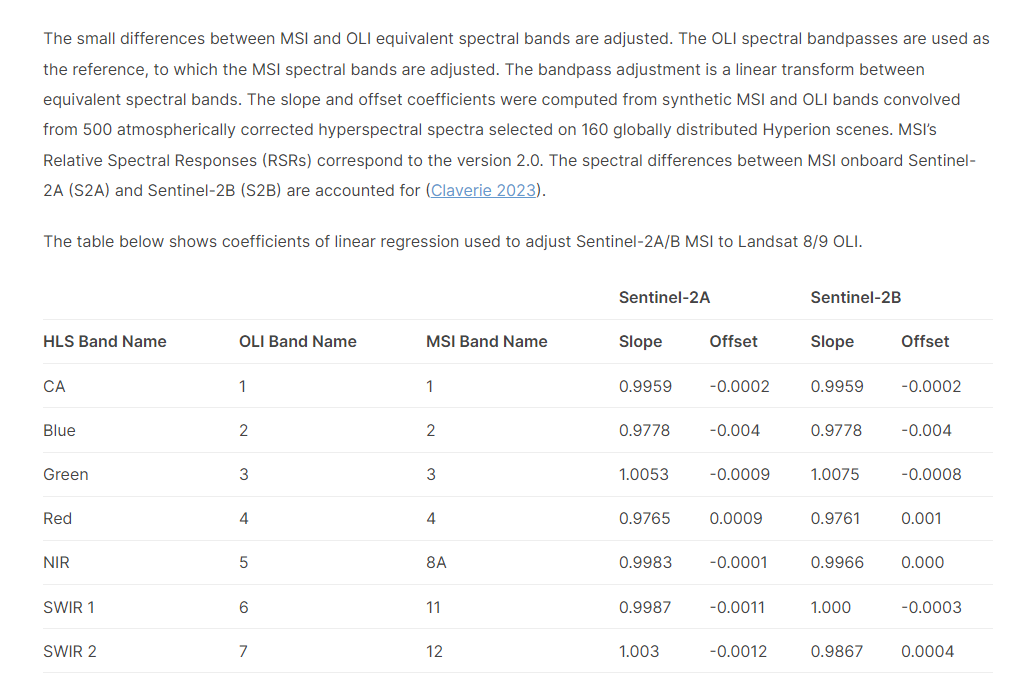

In [25]:
def band_pass_adj(image):

  def s2A(img):
    blue = image.select('blue').multiply(0.9778).subtract(0.004)
    green = image.select('green').multiply(1.0053).subtract(0.0009)
    red = image.select('red').multiply(0.9765).add(0.0009)
    nir=image.select('nir').multiply(0.9983).subtract(0.0001)
    swir1 = image.select('swir1').multiply(0.9987).subtract(0.0011)
    swir2 = image.select('swir2').multiply(1.003).subtract(0.0012)
    return blue.addBands(green).addBands(red).addBands(nir).addBands(swir1).addBands(swir2).copyProperties(image,['system:time_start','CLOUDY_PIXEL_PERCENTAGE',"system:index","GRANULE_ID"])

  def s2B(img):
    blue = image.select('blue').multiply(0.9778).subtract(0.004)
    green = image.select('green').multiply(1.0075).subtract(0.0008)
    red = image.select('red').multiply(0.9761).add(0.001)
    nir=image.select('nir').multiply(0.9966)
    swir1 = image.select('swir1').multiply(1.000).subtract(0.0003)
    swir2 = image.select('swir2').multiply(0.9867).add(-0.0004)
    return blue.addBands(green).addBands(red).addBands(nir).addBands(swir1).addBands(swir2).copyProperties(image,['system:time_start','CLOUDY_PIXEL_PERCENTAGE',"system:index","GRANULE_ID"])

  return ee.Algorithms.If(ee.Algorithms.IsEqual(image.get('SPACECRAFT_NAME'), ee.String("Sentinel-2A")),
                   s2A(image),
                   ee.Algorithms.If(ee.Algorithms.IsEqual(image.get('SPACECRAFT_NAME'), ee.String("Sentinel-2B")),
                                    s2B(image), ee.Image(0).set('ERROR', 'SPACECRAFT_NAME')))




In [ ]:
adj_s2 = brdf_s2.map(band_pass_adj)
adj_s2.limit(2)

# Transform into remote sensing  reflectance and sunglint correction

In [27]:
#dividir imagem corrigida por pi
# Rrs_sat_ac = Rsat_ac / pi

#fazer deglint
#Rrs_sat_ac_deglint(VNIR) = Rrs_sat_ac (VNIR) − Rrs_sat_ac (SWIR)
#correção no artigo INPE CURUAI
def deglint (img):
    Rrs = img.divide(math.pi)
    deglint = Rrs.select(['blue','green','red','nir','swir1'])\
    .subtract(Rrs.select('swir2'))

    return (deglint.updateMask(deglint.select(['red']).gt(0))
    .copyProperties(img,['system:time_start','CLOUD_COVER',"system:index","LANDSAT_PRODUCT_ID","GRANULE_ID","CLOUDY_PIXEL_PERCENTAGE"]))


### Landsat 7

In [28]:
landsat7_rs = brdf_ld7.map(deglint).map(lambda img : img.set("SATELLITE_PRODUCT_ID",img.get("LANDSAT_PRODUCT_ID")))

landsat7_rs.limit(2)

In [66]:
proj_ref = sentinel2.first().select('B4').projection().getInfo()

In [26]:
# task = ee.batch.Export.image.toDrive(
#     image=landsat7_rs.filter(ee.Filter.eq('SATELLITE_PRODUCT_ID','LE07_L1TP_228062_20160831_20200902_02_T1')).first().select(['blue','green','red']),
#     description='ld7_rs_deglint',
#     fileNamePrefix='ld7_rs_deglint',
#     folder='CURIAI_PROCESS',
#     region=ee.Geometry.Polygon(
#         [[[-55.94602179911875, -2.0864683853282586],
#           [-55.94602179911875, -2.1952257180277024],
#           [-55.76989722636485, -2.1952257180277024],
#           [-55.76989722636485, -2.0864683853282586]]], None, False),
#     scale=30,
#     crs=proj_ref['crs']
# )
# task.start()

### Landsat 8

In [29]:
landsat8_rs = brdf_ld8.map(deglint).map(lambda img : img.set("SATELLITE_PRODUCT_ID",img.get("LANDSAT_PRODUCT_ID")))
landsat8_rs.limit(2)

In [28]:
# task = ee.batch.Export.image.toDrive(
#     image=landsat8_rs.filter(ee.Filter.eq('SATELLITE_PRODUCT_ID','LC08_L1TP_228062_20160807_20200906_02_T1')).first().select(['blue','green','red']),
#     description='ld8_rs_deglint',
#     fileNamePrefix='ld8_rs_deglint',
#     folder='CURIAI_PROCESS',
#     region=ee.Geometry.Polygon(
#         [[[-55.94602179911875, -2.0864683853282586],
#           [-55.94602179911875, -2.1952257180277024],
#           [-55.76989722636485, -2.1952257180277024],
#           [-55.76989722636485, -2.0864683853282586]]], None, False),
#     scale=30,
#     crs=proj_ref['crs']
# )
# task.start()

### Sentinel 2

In [30]:
sentinel2_rs = adj_s2.map(deglint).map(lambda img : img.set({"SATELLITE_PRODUCT_ID":img.get("GRANULE_ID"),
                                                          "CLOUD_COVER":img.get("CLOUDY_PIXEL_PERCENTAGE")}))

In [31]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.addLayer(s2.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'s2')
Map.addLayer(ld8.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'ld8')
Map.addLayer(brdf_s2.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'brdf')
Map.addLayer(brdf_ld8.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'ld8 brdf')
Map.addLayer(adj_s2.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'band pass')
Map.addLayer(sentinel2_rs.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'deglint')
Map.addLayer(landsat8_rs.first(),{'bands':['red','green','blue'],min:0.1,max:0.2},'ld8 deglint')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [30]:
# task = ee.batch.Export.image.toDrive(
#     image=sentinel2_rs.filter(ee.Filter.eq('SATELLITE_PRODUCT_ID','S2A_OPER_MSI_L1C_TL_SGS__20160803T191858_A005827_T21MXT_N02.04')).first().select(['blue','green','red']),
#     description='s2_rs_deglint',
#     fileNamePrefix='s2_rs_deglint',
#     folder='CURIAI_PROCESS',
#     region=ee.Geometry.Polygon(
#         [[[-55.94602179911875, -2.0864683853282586],
#           [-55.94602179911875, -2.1952257180277024],
#           [-55.76989722636485, -2.1952257180277024],
#           [-55.76989722636485, -2.0864683853282586]]], None, False),
#     scale=30,
#     crs=proj_ref['crs']
# )
# task.start()

# Merge Harmonized Collections

In [32]:
harmonized_images = sentinel2_rs.merge(landsat8_rs).merge(landsat7_rs).sort('system:time_start')

# Sample multiple points for the entire collection

obtain statistics for the same location of the field point - with a 3 pixel window - and filter out if more than 4 pixels are masked   

In [33]:
roi_polys = roi_points.map(lambda pt: ee.Feature(pt.geometry().buffer(45).bounds()).set('ID',pt.get('ID'))).filter(ee.Filter.eq('ID',320))
roi_polys.size()

In [34]:
def zonalStats(ic, fc, params=None):
  _params = {
    'reducer': ee.Reducer.mean(),
    'scale': None,
    'crs': None,
    'bands': None,
    'imgProps': None,
  }
  # // Replace initialized params with provided params.
  # Replace initialized params with provided params
  if params:
     for param, value in params.items():
      _params[param] = value or _params[param]


  # // Map the reduceRegions function over the image collection.
  def reduceRegionfunction (img):
    # // Select bands, set a datetime & timestamp property.
    img = ee.Image(img.select(_params['bands']))\
      .set('datetime', ee.Date(img.get('system:time_start')).format('YYYY-MM-dd HH:mm:ss'))\
      .set('timestamp', img.get('system:time_start'));

    list_props = ee.List(_params['imgProps']).cat(['datetime','timestamp'])
    imgProps = img.toDictionary(list_props)


    # // Subset points that intersect the given image.
    fcSub = fc.filterBounds(img.geometry())

    # // Reduce the image by regions.
    return img.reduceRegions(**{
      'collection': fcSub,
      'reducer': _params['reducer'],
      'scale': _params['scale'],
      'crs': _params['crs']
    }).map(lambda f : f.set(imgProps).set())# // Add metadata to each feature.


  results = ic.map(reduceRegionfunction).flatten().filter(ee.Filter.gt('blue_count',3))

  return results

In [35]:
params = {
    'reducer': ee.Reducer.mean().combine(ee.Reducer.minMax(),sharedInputs=True)\
    .combine(ee.Reducer.count(),sharedInputs=True)\
    .combine(ee.Reducer.stdDev(),sharedInputs=True)\
    .combine(ee.Reducer.median(),sharedInputs=True).unweighted(),
    'scale': 30,
    'bands': ['blue','green','red','nir'],
    'imgProps': ["SATELLITE_PRODUCT_ID", 'CLOUD_COVER']
  }

In [36]:
stats = zonalStats(harmonized_images,roi_polys,params)

# Export data as CSV file

In [37]:
#Exportar tabelas
# Export the image sample feature collection to Drive as a CSV file.
task = ee.batch.Export.table.toDrive(
    collection=stats,
    description='scalled_brdf_bandpassATT_deglint',
    folder='CURUAI_PROCESS',
    fileNamePrefix='scalled_brdf_bandpassATT_deglint',
    fileFormat='CSV',
)
task.start()